In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
from finrl.meta.preprocessor.preprocessors import data_split
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from utils.feature_engineer import FeatureEngineer
from models import DRLAgent
import sys

sys.path.append("../FinRL-Library")
plt.style.use('science')

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from pandas import read_csv

def add_volatility(df, periods=21):
    rolling_volatility = df.groupby('tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility
    
    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)
    
    return df
    


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

Dow Jones Industrial Average
The Dow Jones Industrial Average, Dow Jones, or simply the Dow, is a stock market index of 30 prominent companies listed on stock exchanges in the United States. The DJIA is one of the oldest and most commonly followed equity indexes. 


Constituents: 30

Exchanges: New York Stock Exchange; Nasdaq

Foundation: February 16, 1885; 139 years ago (as DJA); May 26, 1896 (as DJIA)

Market cap: US$12.0 trillion; (as of December 29, 2023)

Trading symbol: ^DJI; $INDU.DJI; DJIA

Weighting method: Price-weighted index

### ENV Creation

In [62]:
df =df_dow.copy()


In [63]:
columns = reduced_data.columns.tolist()
df = df_dow[df_dow.tic.isin(columns)]


In [64]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "rsi",
    "atr",
    "close_21_ema",
    "close_62_ema"
    ,"macd"
    ]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 7


In [41]:
cleaned_data = cleaned_data[cleaned_data.tic.isin(['AAPL', 'AXP', 'DIS', 'MMM', 'IBM'])]
cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 5


In [6]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
Columns retained after filtering: ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']


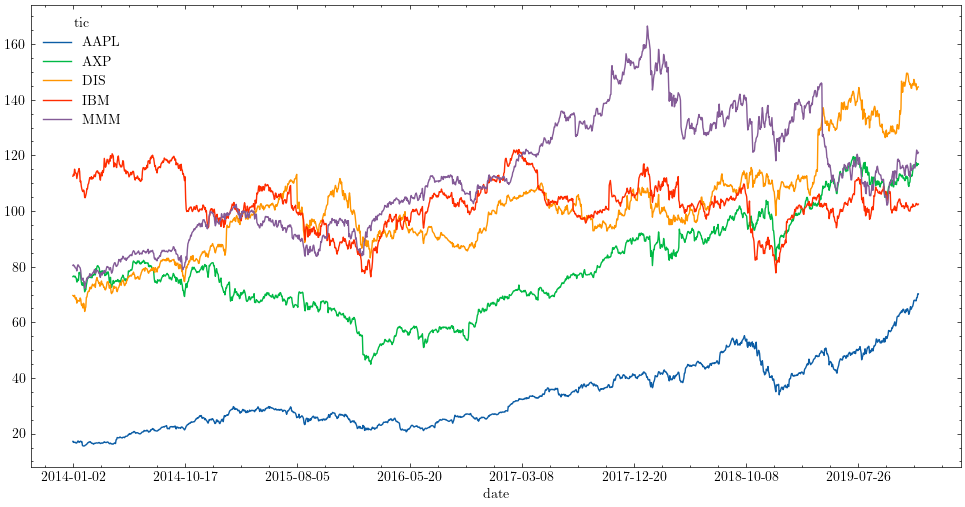

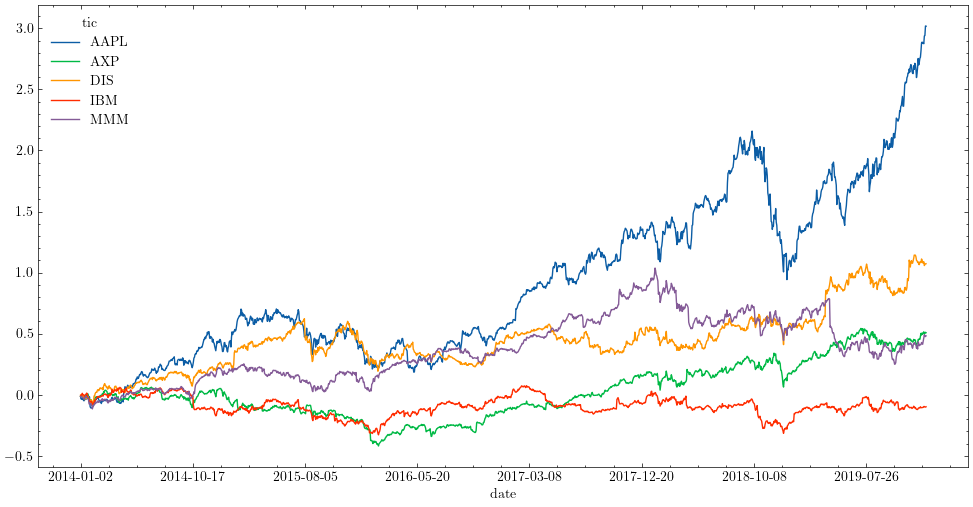

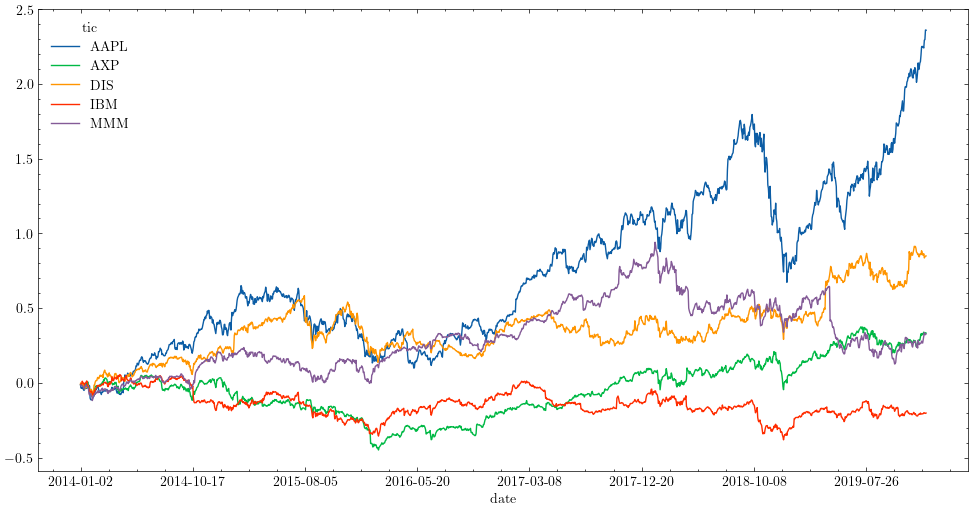

In [52]:
data = train_data
pv = data.pivot(values='return',columns='tic',index='date')
pv2 = data.pivot(values='log_return',columns='tic',index='date')

cumulative_return = (1 + pv).cumprod() -1
cumulative_return2 = (1 + pv2).cumprod() -1

%matplotlib inline
with plt.style.context('science','ieee'):
    pv = data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(12,6))
    cumulative_return.plot(figsize=(12, 6))
    cumulative_return2.plot(figsize=(12, 6))
    

    

### PPO Trend indicators ema 21,62


![ppo](./screenshots/ppo.png)

assets : ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']

dates : TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

Trend Indicators with state normalization based on previous time.

Model could converge but not rebalancing too often

In [7]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema","close_62_ema"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dow30_chl',transaction_fee = 0.003,load=True,
                         model_path='./data/history_main_close.close_21_ema.close_62_ema_dow30_chl/best/best_model'
)

Initial portfolio value:250000
Final portfolio value: 334389.4375
Final accumulative portfolio value: 1.33755775
Maximum DrawDown: -0.21096650764847402
Sharpe ratio: 0.5976140495425616
hit end!


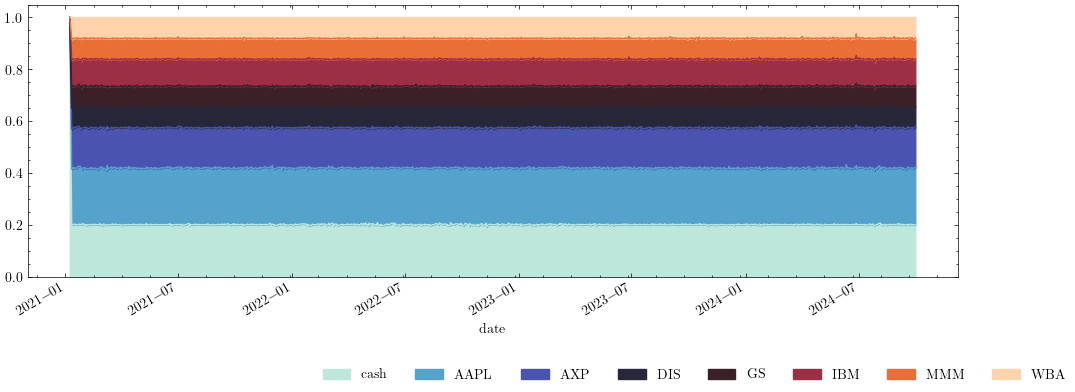

In [8]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns =['cash'] + columns
%matplotlib inline
with plt.style.context('science','ieee'):
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire").legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    # zz = result_ppo['test'][0]['daily_return']
    # zz.index=result_ppo['test'][0]['date']
    # print('max drowdown:', qs.stats.max_drawdown(result_ppo['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_ppo['test'][0].daily_return))
    # qs.plots.snapshot(zz)


Losts of usesless trades
acting similar to buy and hold but seems overfitted to training
does not seem to capture the trends meaningfully

### PPO Trend Indicators SHARPE reward

![ppo](./screenshots/ppo_sharpe.png)

assets : ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']

dates : TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

Sharpe reward for last 62 returns. 
weights are constant

In [23]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema","close_62_ema"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dow30_sharpe',sharpe_reward=True,transaction_fee = 0.003,
                         load=True,last_weight=False,remove_close=False,
                         model_path='./data/history_main_close.close_21_ema.close_62_ema_dow30_sharpe/ppo_950000_steps'
)

Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 293791.875
Final accumulative portfolio value: 1.1751675
Maximum DrawDown: -0.24393601408112098
Sharpe ratio: 0.3580548574316915
hit end!


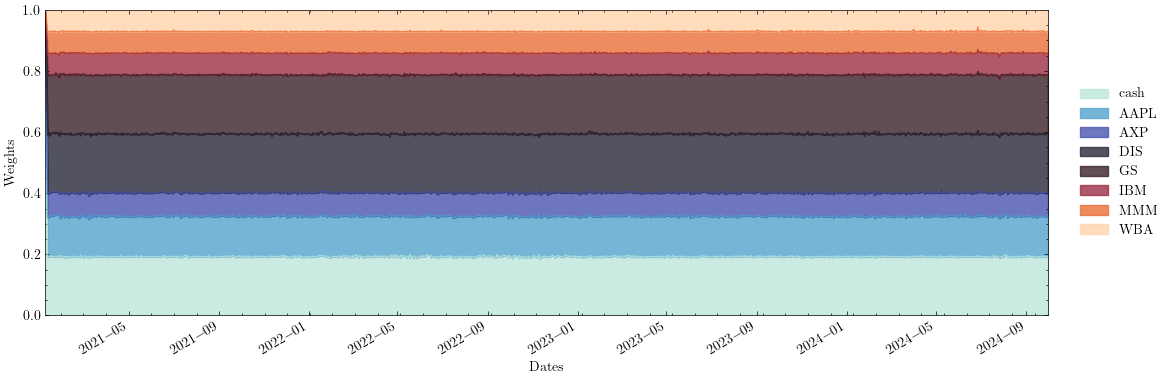

In [24]:
plot_weights(result_ppo,True,test_data)

## PPO without transaction cost

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema"]
                         ,iterations=iterations,model_name='ppo',tag='without_fee',transaction_fee = 0
                         ,comission_fee_model = None,
                        load=True,last_weight=False,remove_close=False,
                         model_path='./data/history_main_close.close_21_ema_without_fee/ppo_110000_steps')

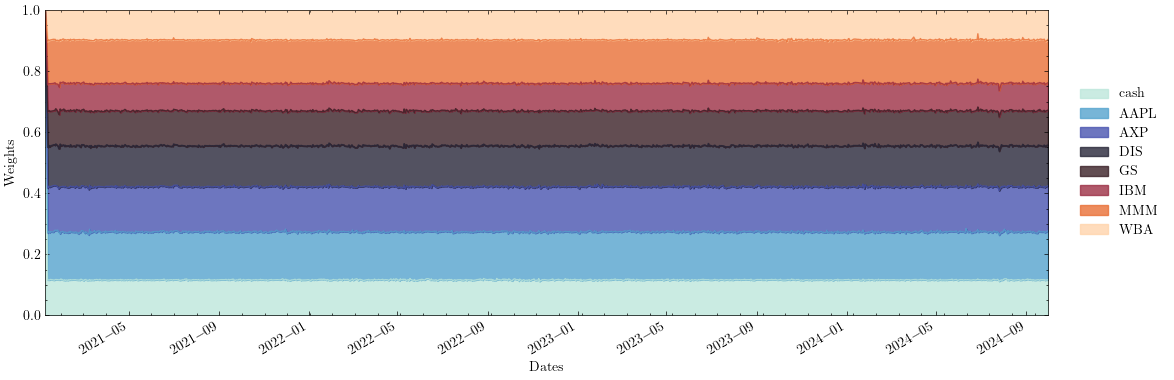

In [29]:
plot_weights(result_ppo,True,test_data)

## PPO high transaction cost RSI ATR MACD

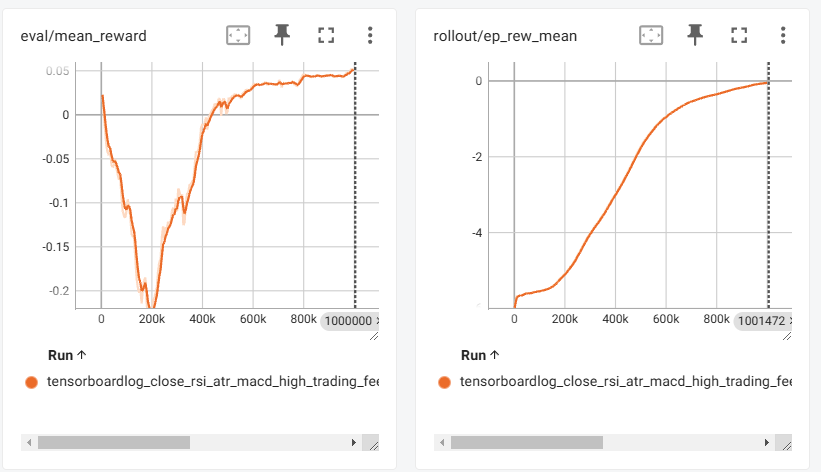

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee',transaction_fee = 0.01
                         ,comission_fee_model = "trf",load=True,last_weight=False,remove_close=False,
                         model_path='./data/history_main_close.rsi.atr.macd_high_trading_fee/ppo_500000_steps')

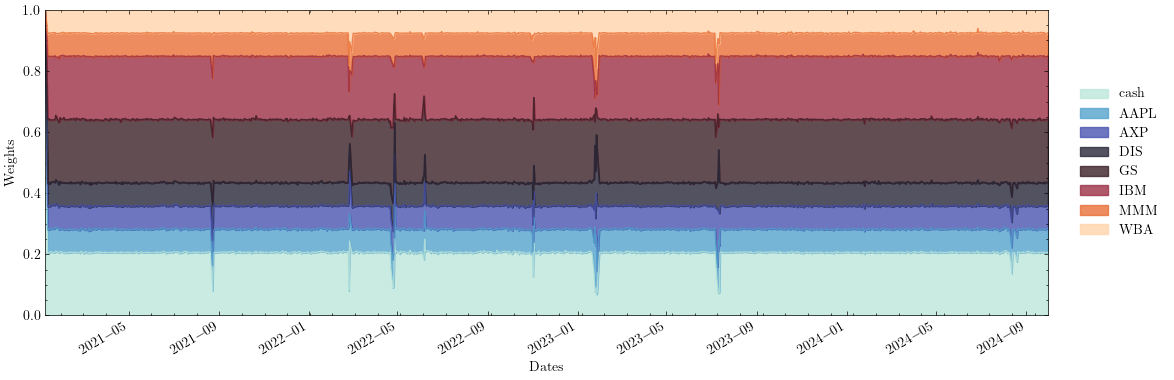

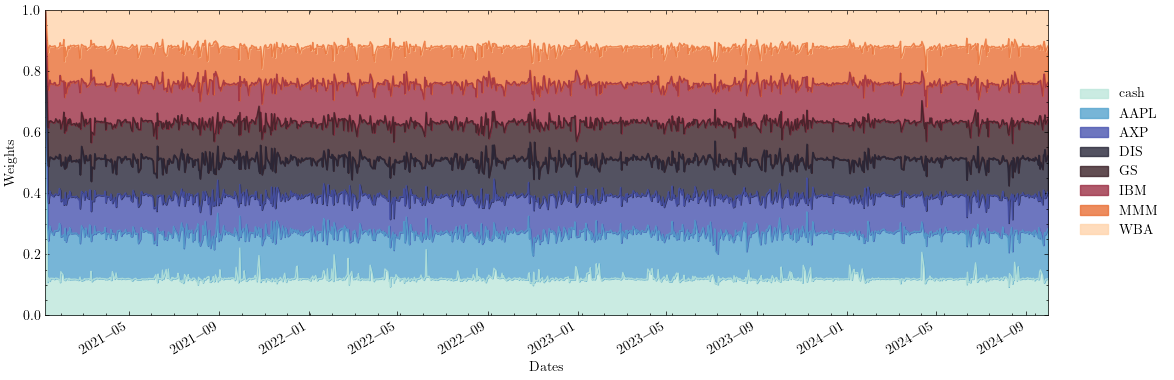

In [15]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

## MVO WEIGHTS

In [25]:
from archive.utils import mvo_data,mvo
correlation_data = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE)
min_variance_portfolio = mvo(correlation_data,pct=0.003)


begin_total_asset:50000
end_total_asset:46009.67340582171
Sharpe:  1.212018470241221
Test Finished!
episode_return 0.9201934681164342


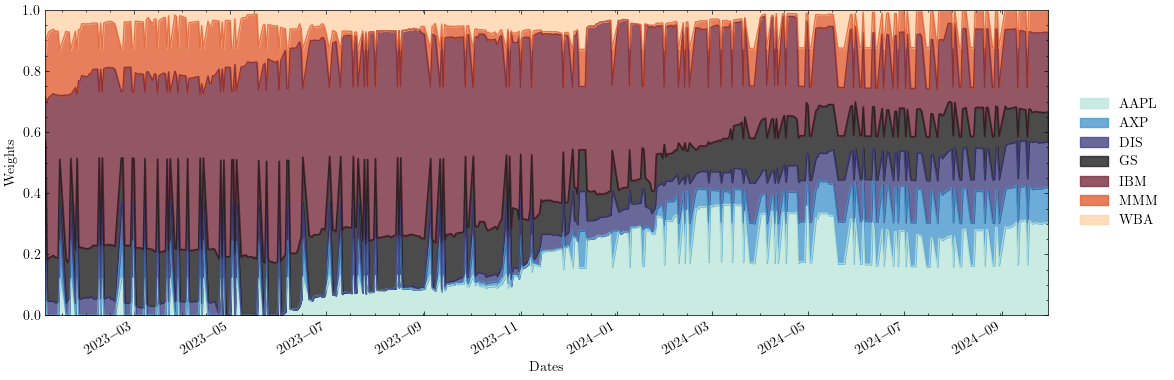

In [26]:
plot_mvo_weights(min_variance_portfolio,test_data)

# PPO 0.005 transaction cost RSI ATR MACD

In [ ]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee',transaction_fee = 0.005
                         ,comission_fee_model = "trf")


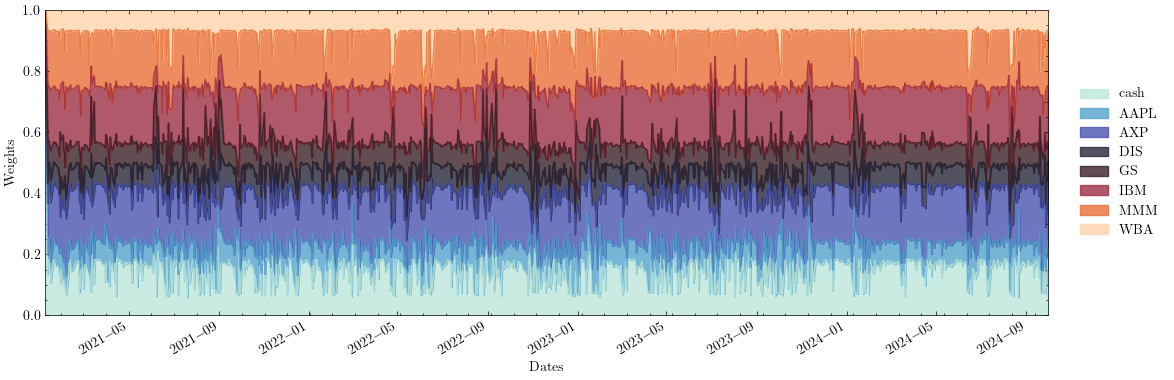

In [25]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

RSI , MACD

In [56]:
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "trf",load=True,
                         model_path='./data/history_main_close.rsi.atr.macd_high_trading_fee_0.01/ppo_100000_steps')

Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 98602.1953125
Final accumulative portfolio value: 0.39440878125
Maximum DrawDown: -0.6510428970036883
Sharpe ratio: -1.61835376896093
hit end!


In [ ]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.005
                         ,comission_fee_model = "trf")


# PPO simple close window 21 days

In [ ]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return"],t=21
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "wvm",normalize=None)


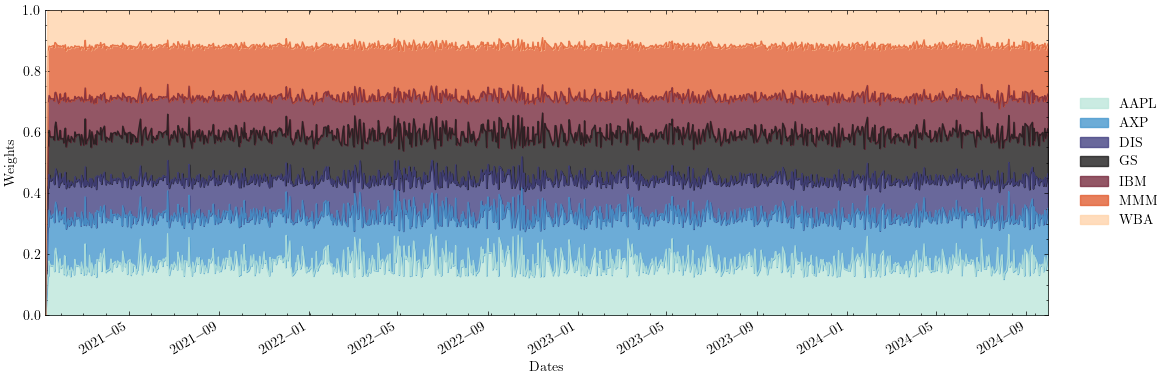

In [46]:
plot_wights(result_ppo)

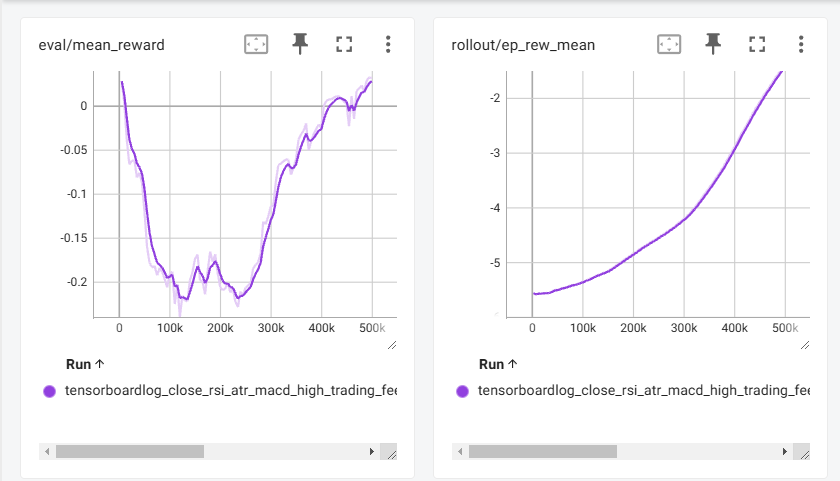

21 days state window.
more Rebalances

In [52]:
result_ppo = train_model(train_data,train_data,validation_data,features=["close","log_return"],t=21
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "wvm",normalize=None
                         ,load=True,
                         model_path='./data/history_main_close.log_return_high_trading_fee_0.01/ppo_100000_steps')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 73111.828125
Final accumulative portfolio value: 0.2924473125
Maximum DrawDown: -0.739623463169869
Sharpe ratio: -1.3172909981750076
hit end!


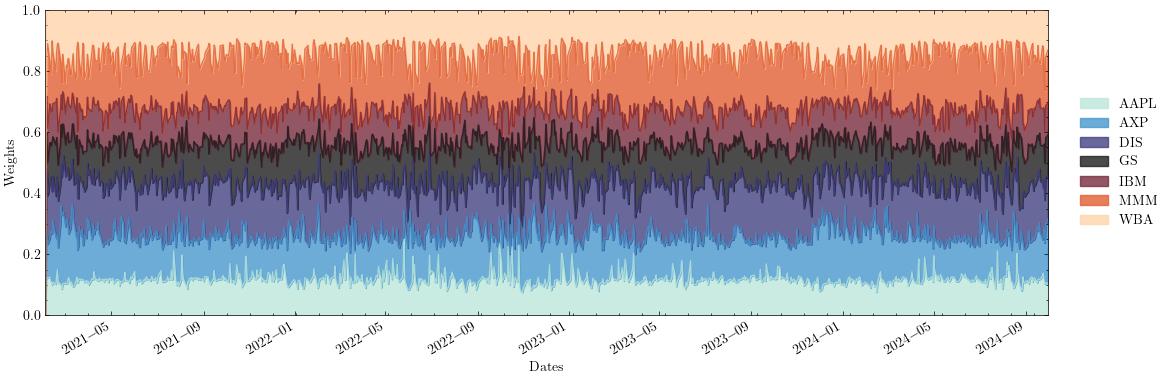

In [51]:
plot_wights(result_ppo)

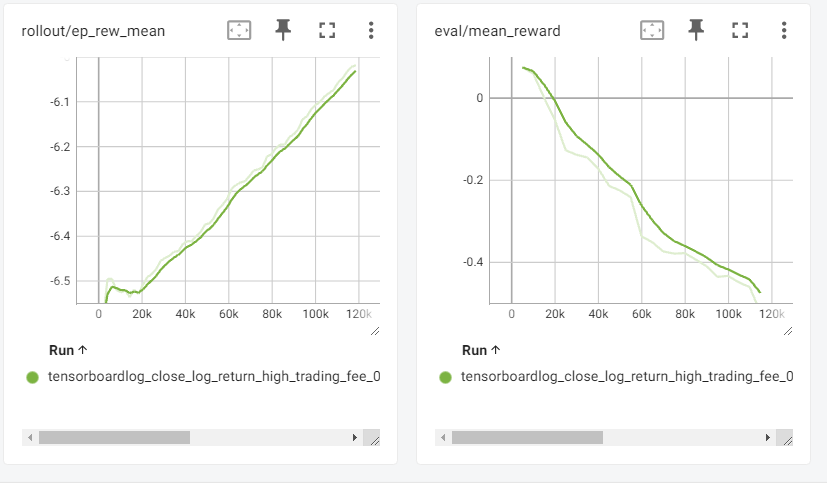

In [ ]:
def calc_train_trade_starts_ends_if_rolling(
    init_train_dates: list[str], init_trade_dates: list[str], rolling_window_length: int
) -> tuple[list[str], list[str], list[str], list[str]]:
    trade_dates_length = len(init_trade_dates)
    train_window_length = len(init_train_dates)
    trade_window_length = min(rolling_window_length, trade_dates_length)
    num_subsets_if_rolling = int(np.ceil(trade_dates_length / trade_window_length))
    print("num_subsets_if_rolling: ", num_subsets_if_rolling)
    dates = np.concatenate((init_train_dates, init_trade_dates), axis=0)
    train_starts = []
    train_ends = []
    trade_starts = []
    trade_ends = []

    for i in range(num_subsets_if_rolling):
        trade_start_index = train_window_length + i * trade_window_length
        trade_start = dates[trade_start_index]
        trade_starts.append(trade_start)
        trade_end_index = min(trade_start_index + trade_window_length, len(dates) - 1)
        trade_end = dates[trade_end_index]
        trade_ends.append(trade_end)
        train_start = dates[trade_start_index - train_window_length]
        train_starts.append(train_start)
        train_end = dates[trade_start_index]
        train_ends.append(train_end)
    print("train_starts: ", train_starts)
    print("train_ends__: ", train_ends)
    print("trade_starts: ", trade_starts)
    print("trade_ends__: ", trade_ends)
    return train_starts, train_ends, trade_starts, trade_ends


In [ ]:
from finrl.meta.data_processors.func import calc_train_trade_data
date_col = 'date'
rolling_window_length = 252
init_train_dates = train_data[date_col].unique()
init_trade_dates = test_data[date_col].unique()
(
    train_starts,
    train_ends,
    trade_starts,
    trade_ends,
) = calc_train_trade_starts_ends_if_rolling(
    init_train_dates, init_trade_dates, rolling_window_length
)
len(train_starts)
ongoing_model = None
model_name = 'ppo'
tag = 'rolling_window'
iterations = 50000
for i in range(len(train_starts)):
    print("i: ", i)
    train_data_, trade_data_ = calc_train_trade_data(
        i,
        train_starts,
        train_ends,
        trade_starts,
        trade_ends,
        train_data,
        test_data,
        date_col,
    )
    if ongoing_model == None:
        ongoing_model = train_model(train_data_,trade_data_,validation_data,features=["close","log_return","volatility"],t=5
                            ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.01
                            ,comission_fee_model = "wvm",normalize=None)
    else:
        ongoing_model = train_model(train_data_,trade_data_,validation_data,features=["close","log_return","volatility"],t=5
                    ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.01
                    ,comission_fee_model = "wvm",normalize=None,load_continue=True
                    ,model_path='./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag)

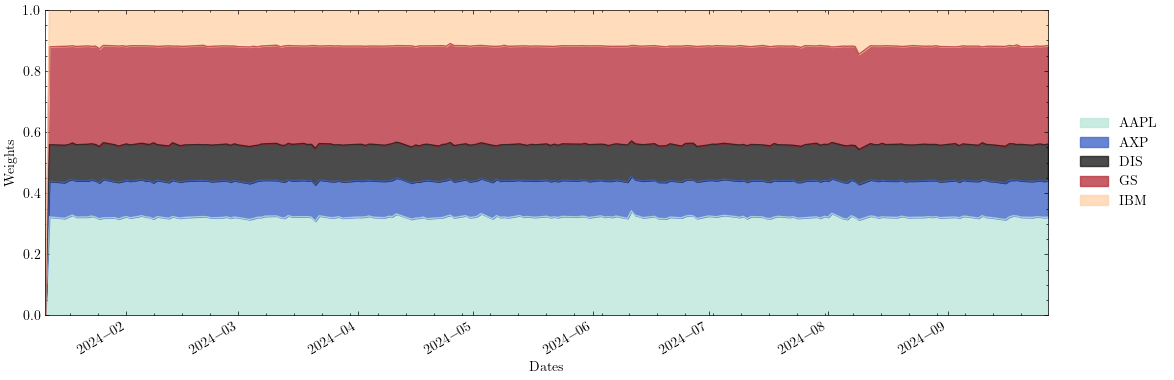

In [43]:
plot_wights(ongoing_model)

['AAPL', 'AXP', 'DIS', 'MMM', 'IBM']

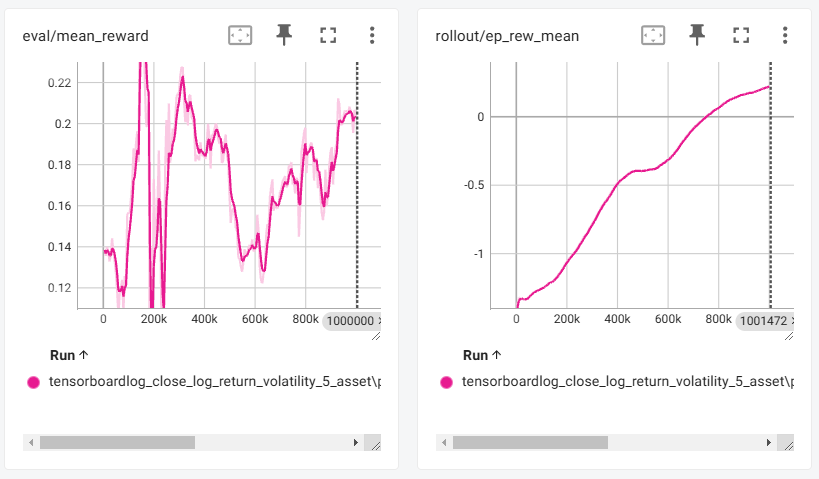

# Just std of returns over past 21 days.
No state normalization
active rebalancing

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.001,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset/ppo_800000_steps')


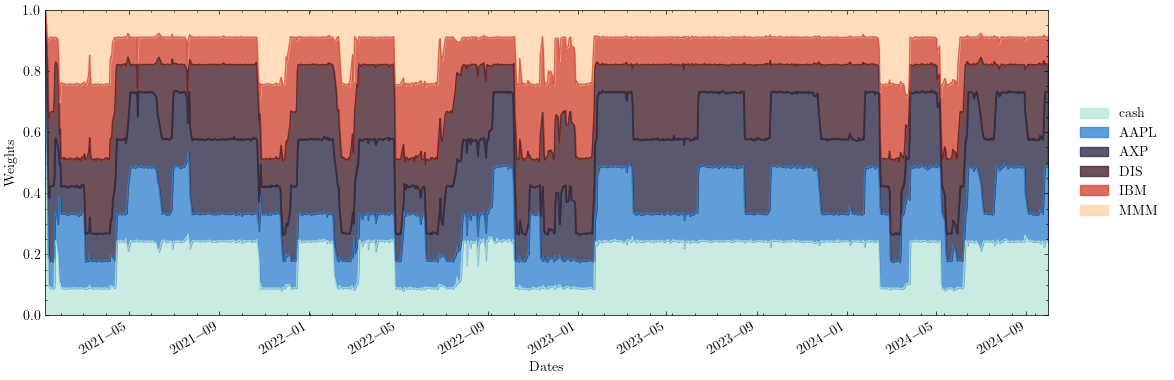

In [40]:
plot_weights(result_ppo,True,test_data)

In [ ]:
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.003,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset/ppo_50000_steps')

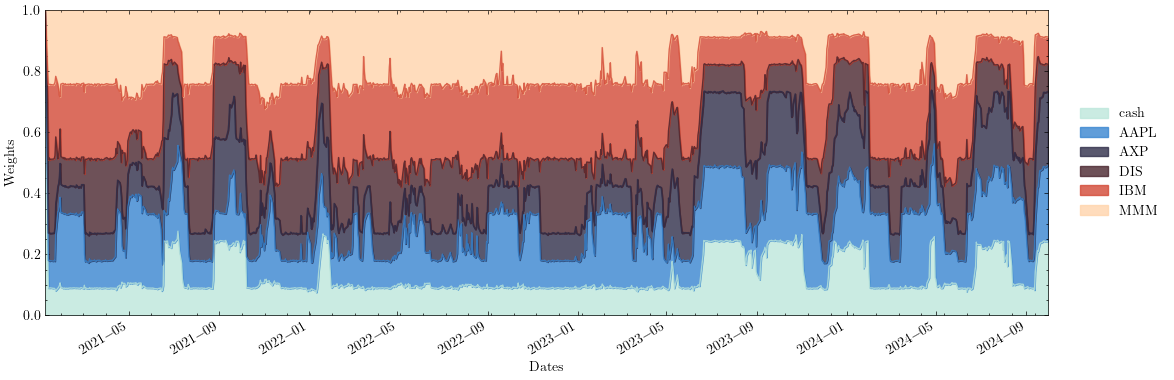

In [23]:
plot_weights(result_ppo,True)

In [45]:
iterations = 1000_000
result_ppo_3 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility","rsi","atr"],normalize=None
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                        ,transaction_fee = 0.003,load=True,model_path='./data/history_main_close.log_return.volatility.rsi.atr_5_asset/ppo_500000_steps')


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 292853.53125
Final accumulative portfolio value: 1.171414125
Maximum DrawDown: -0.2441995533835677
Sharpe ratio: 0.36002105388466105
hit end!


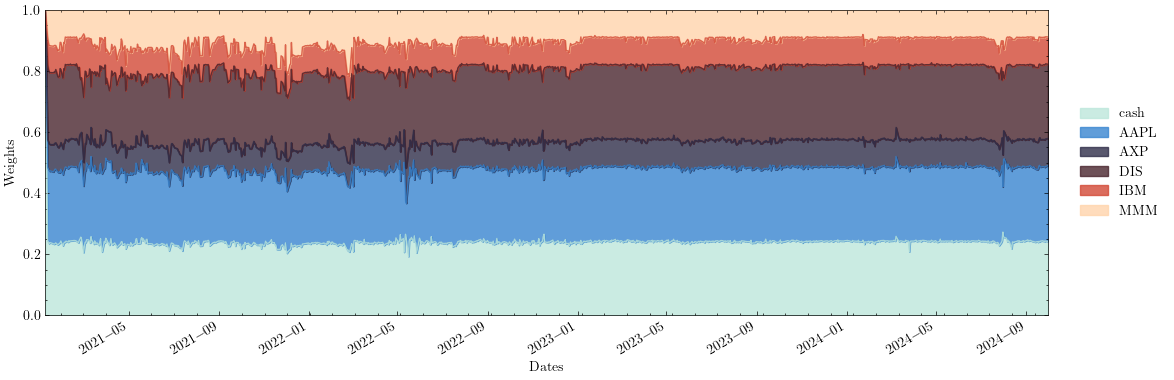

In [46]:
plot_weights(result_ppo_3,True,test_data)

test case = High trading fee , normalize state

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","volatility"],normalize="by_previous_time"
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset_normalize_high_fee'
                         ,transaction_fee = 0.01)

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","volatility"],normalize="by_previous_time"
                        ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset_normalize_high_fee'
                        ,transaction_fee = 0.003,load=True,model_path='./data/history_main_close.volatility_5_asset_normalize_high_fee/ppo_300000_steps')

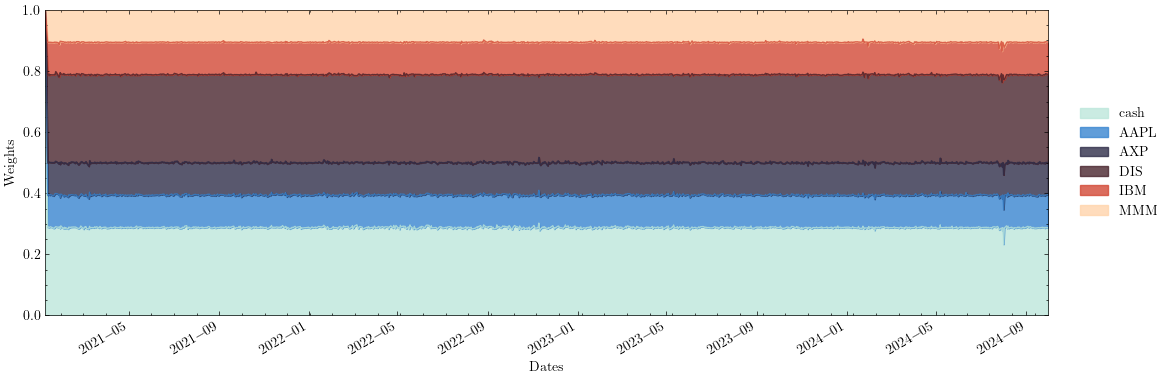

In [9]:
plot_weights(result_ppo,True,test_data)

Indicators. not normalized

In [ ]:
iterations = 1000_000
result_ppo_3 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility","rsi","atr"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.003
)

In [16]:
stock_dimension = len(test_data.tic.unique()) +1

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.003,
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1398714.25
Final accumulative portfolio value: 1.39871425
Maximum DrawDown: -0.2245954406113726
Sharpe ratio: 0.6603069356189577


In [ ]:
environment_train_buy_and_hold._final_weights

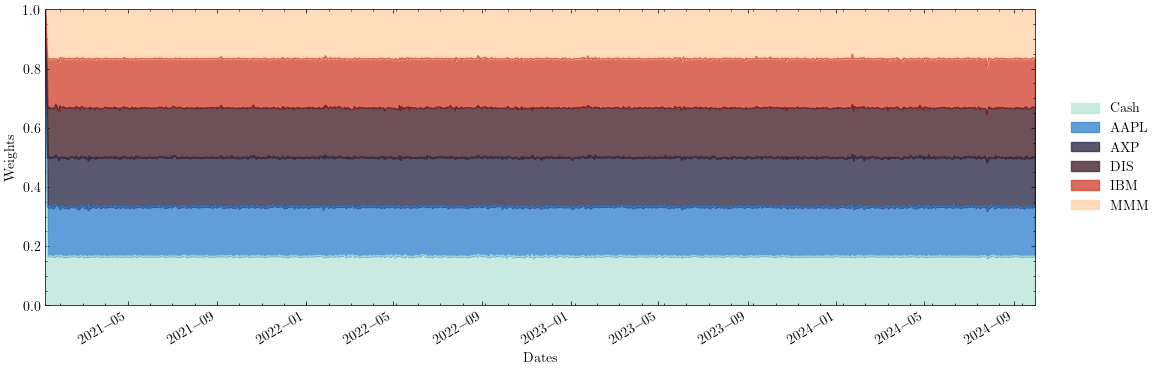

In [25]:
w = pd.DataFrame(environment_train_buy_and_hold._final_weights)
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = environment_train_buy_and_hold._date_memory
w.columns = ['Cash']+columns

%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
plt.tight_layout()

In [14]:
init_train_dates

array(['2014-01-02', '2014-01-03', '2014-01-06', ..., '2019-12-24',
       '2019-12-26', '2019-12-27'], dtype=object)

In [13]:
from finrl.meta.data_processors.func import calc_train_trade_data
date_col = 'date'
rolling_window_length = 252
init_train_dates = train_data[date_col].unique()
init_trade_dates = test_data[date_col].unique()
(
    train_starts,
    train_ends,
    trade_starts,
    trade_ends,
) = calc_train_trade_starts_ends_if_rolling(
    init_train_dates, init_trade_dates, rolling_window_length
)
display(train_starts)
display(train_ends)

# ongoing_model = None
# model_name = 'ppo'
# tag = 'rolling_window'
# iterations = 50000
# for i in range(len(train_starts)):
#     train_data_, trade_data_ = calc_train_trade_data(
#         i,
#         train_starts,
#         train_ends,
#         trade_starts,
#         trade_ends,
#         train_data,
#         test_data,
#         date_col,
#     )
#     display(train_data_)
#     # if ongoing_model == None:
#     #     ongoing_model = train_model(train_data_,trade_data_,validation_data,features=["close","log_return","volatility"],t=5
#     #                         ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.01
#     #                         ,comission_fee_model = "wvm",normalize=None)
#     # else:
#     #     ongoing_model = train_model(train_data_,trade_data_,validation_data,features=["close","log_return","volatility"],t=5
#     #                 ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.01
#     #                 ,comission_fee_model = "wvm",normalize=None,load_continue=True
#     #                 ,model_path='./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag)

num_subsets_if_rolling:  4
train_starts:  ['2014-01-02', '2015-01-02', '2016-01-04', '2017-01-03']
train_ends__:  ['2021-01-04', '2022-01-03', '2023-01-04', '2024-01-05']
trade_starts:  ['2021-01-04', '2022-01-03', '2023-01-04', '2024-01-05']
trade_ends__:  ['2022-01-03', '2023-01-04', '2024-01-05', '2024-09-30']


['2014-01-02', '2015-01-02', '2016-01-04', '2017-01-03']

['2021-01-04', '2022-01-03', '2023-01-04', '2024-01-05']

In [5]:

import pandas as pd

def rolling_window_split(df, train_window=252, test_window=21):
    windows = []  # List to store tuples of (train_df, test_df)

    # Sort the dataframe by date (chronologically), ensuring the dataset is in correct order
    df = df.sort_values(by=['date'])

    # Get the unique dates in the dataset (these will be the boundaries for rolling windows)
    unique_dates = df['date'].unique()

    # Loop through the dates and create rolling windows
    for start_idx in range(0, len(unique_dates) - train_window - test_window + 1, train_window):
        # Get the start and end dates for the training window
        train_start_date = unique_dates[start_idx]
        train_end_date = unique_dates[start_idx + train_window - 1]
        
        # Get the start and end dates for the testing window
        test_start_date = unique_dates[start_idx + train_window]
        test_end_date = unique_dates[start_idx + train_window + test_window - 1]

        # Get the training and testing data for all tickers in the current window
        train_data = df[(df['date'] >= train_start_date) & (df['date'] <= train_end_date)]
        test_data = df[(df['date'] >= test_start_date) & (df['date'] <= test_end_date)]

        # Append the training and testing data as a tuple to the windows list
        if len(train_data) == train_window * len(df['tic'].unique()) and len(test_data) == test_window * len(df['tic'].unique()):
            windows.append((train_data, test_data))
    return windows


In [19]:
def rolling_window_trainer(train_data,test_data,evaluation_data,transaction_fee=0.001,model_name='a2c'
                ,iterations = 100_000,tag='tag',features=["close", "log_return"],t=5,args=None,starting_capital = 100_000,model_path=None,
                comission_fee_model = 'trf',normalize = None, n = 0):
    env_kwargs = {
        "initial_amount": starting_capital, 
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        'remove_close_from_state':True,
        "normalize_df":normalize,
        'comission_fee_model':comission_fee_model,
        "return_last_action" : True
    }
    evaluation_environment = PortfolioOptimizationEnv(df = evaluation_data, **env_kwargs)
    evaluation_environment._seed(142)
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    train_environment._seed(142)
    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    test_environment._seed(142)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  policy = "MultiInputPolicy",
                                  tensorboard_log = './tensorboardlog_rolling_'+'_'.join(features)+'_'+tag+'/',
                                  model_kwargs = args)

    checkpoint_callback = CheckpointCallback(save_freq=10000,
                                             save_path='./data/history_rolling_'+'.'.join(features)+'_'+tag+'_window_'+str(n)+'/',
                                                 name_prefix=model_name)
    eval_callback = EvalCallback(
        evaluation_environment, 
        best_model_save_path='./data/history_rolling_'+'.'.join(features)+'_'+tag+'/best',
        log_path='./tensorboardlog_rolling_'+'_'.join(features)+'/',              # Path to save evaluation logs
        eval_freq=5000,                            # Evaluate every 5000 steps
        deterministic=True,                        # Use deterministic actions during evaluation
        render=False                               # Don't render the environment during evaluation
    )
    if model_path == None:
        print('Further traning')
        model = agent.train_model(model=model_agent, 
                        tb_log_name=model_name,
                        total_timesteps=iterations,checkpoint_callback=checkpoint_callback,eval_callbakc=eval_callback)
    else:
        model = model_agent.load(model_path, env =train_environment )
        agent.train_model(model=model, 
            tb_log_name=model_name,
            total_timesteps=iterations,checkpoint_callback=checkpoint_callback,eval_callbakc=eval_callback)

    model.save('./data/rolling_window_trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results

In [ ]:
df = cleaned_data.query('date>"2015-01-01" & date < "2022-01-01"')
windows = rolling_window_split(df)
len(windows)

6

In [26]:
df = cleaned_data.query('date > "2022-01-01"')

In [ ]:
tag = 'rolling_window_6_years'
model_name = 'ppo'
iterations = 252 * 100
continue_training = False
for i in range(len(windows)):
    train = windows[i][0]
    test = windows[i][1]
    display(train)
    if continue_training == False:
        ongoing_model = rolling_window_trainer(train,test,validation_data,features=["close","log_return","volatility"]
                            ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.003,n=i)
        continue_training = True
    else:
        ongoing_model = rolling_window_trainer(train,test,validation_data,features=["close","log_return","volatility"]
                    ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.003
                    ,model_path='./data/rolling_window_trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag,n=i)
    continue_training = False
    


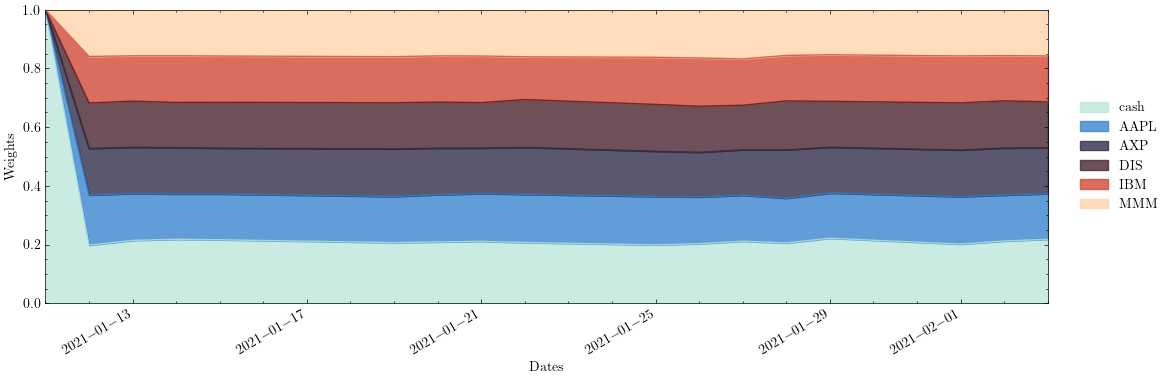

In [ ]:
plot_weights(ongoing_model,True,test_data)

Different time

In [28]:
df = df_dow.copy()

In [41]:
columns = reduced_data.columns.tolist()
df = df[df.tic.isin(['AAPL', 'AXP', 'DIS', 'MMM', 'IBM'])]

In [42]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2019-01-01'

VALIDATION_START_DATE = '2019-01-02'
VALIDATION_END_DATE = '2020-01-01'

TEST_START_DATE = '2020-01-02'
TEST_END_DATE = '2024-12-31'
INDICATORS = [
    "rsi",
    "atr",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2012-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 5


In [ ]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

In [43]:
cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 5


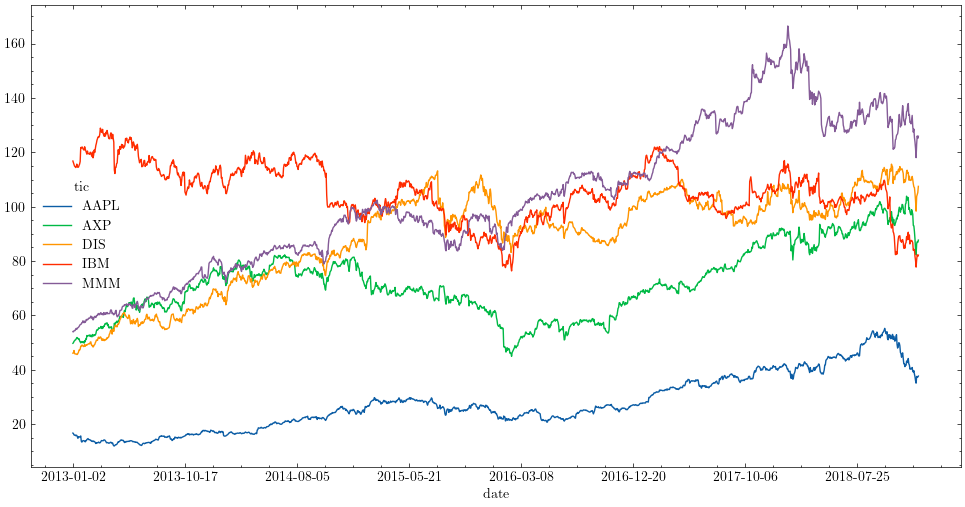

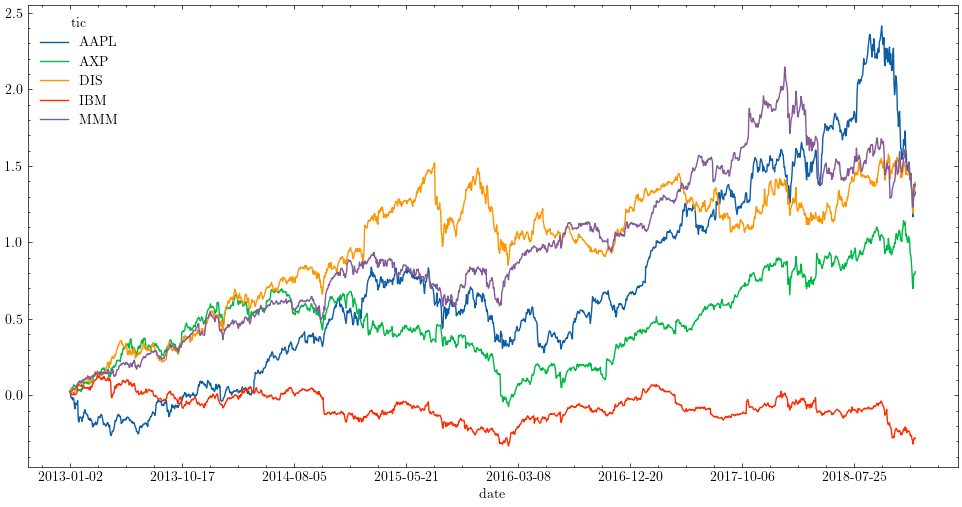

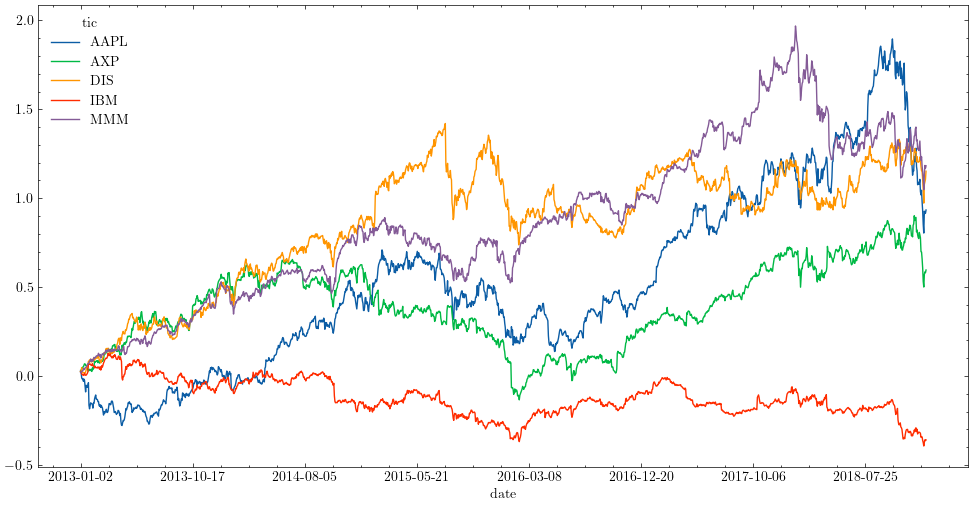

In [35]:
data = train_data
pv = data.pivot(values='return',columns='tic',index='date')
pv2 = data.pivot(values='log_return',columns='tic',index='date')

cumulative_return = (1 + pv).cumprod() -1
cumulative_return2 = (1 + pv2).cumprod() -1

%matplotlib inline
with plt.style.context('science','ieee'):
    pv = data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(12,6))
    cumulative_return.plot(figsize=(12, 6))
    cumulative_return2.plot(figsize=(12, 6))
    

PPO

In [ ]:
iterations = 1_000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 21
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset_0.003_'
                         ,transaction_fee = 0.003
                         ,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset_0.003_/ppo_600000_steps')

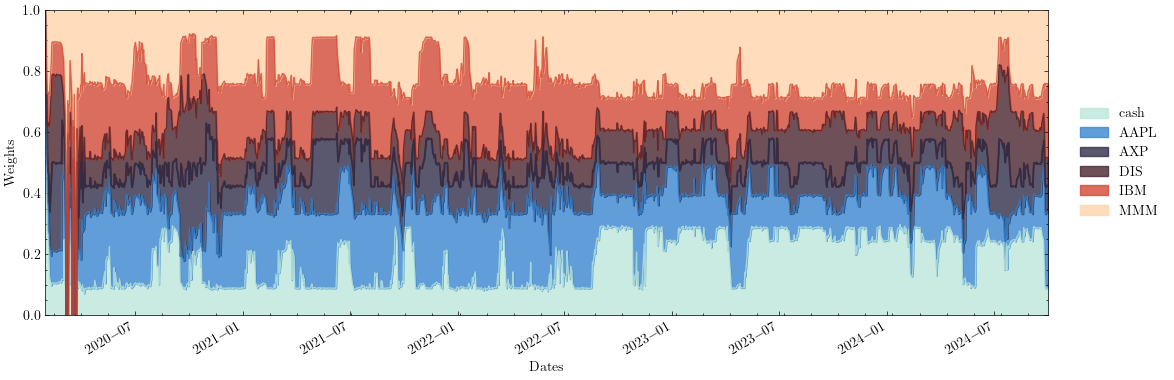

In [40]:
plot_weights(result_ppo,True,test_data)

# MVO

In [58]:
from archive.utils import mvo_data,mvo
correlation_data = mvo_data(cleaned_data,TEST_START_DATE= TEST_START_DATE,TEST_END_DATE=TEST_END_DATE)


In [61]:
min_variance_portfolio = mvo(correlation_data,pct=0.003)


begin_total_asset:50000
end_total_asset:59151.81502160363
Sharpe:  1.7121342911704325
Test Finished!
episode_return 1.1830363004320725


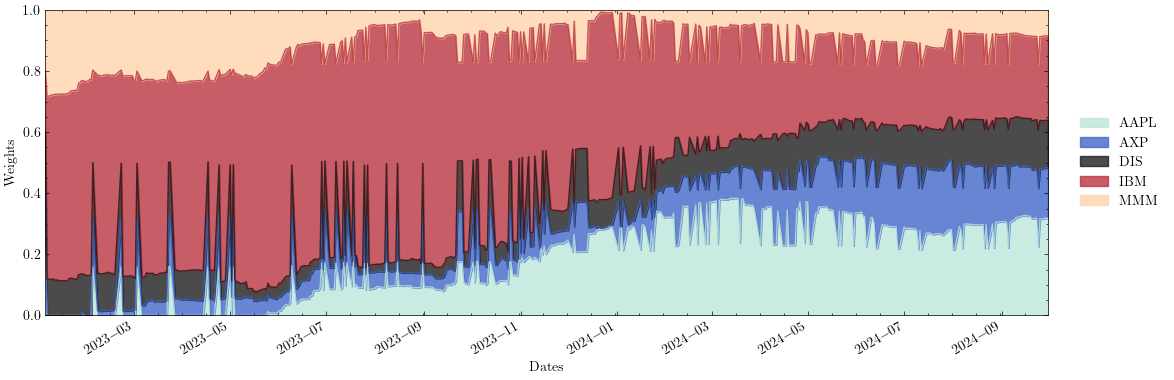

In [60]:
plot_mvo_weights(min_variance_portfolio,test_data)

# Buy and hold acts better because of transcation fee

In [54]:
stock_dimension = len(test_data.tic.unique()) +1

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.003,
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1629562.75
Final accumulative portfolio value: 1.62956275
Maximum DrawDown: -0.3176876999254806
Sharpe ratio: 0.6038567122086399


In [60]:
environment_train_buy_and_hold._tic_list

array(['AAPL', 'AXP', 'DIS', 'IBM', 'MMM'], dtype=object)

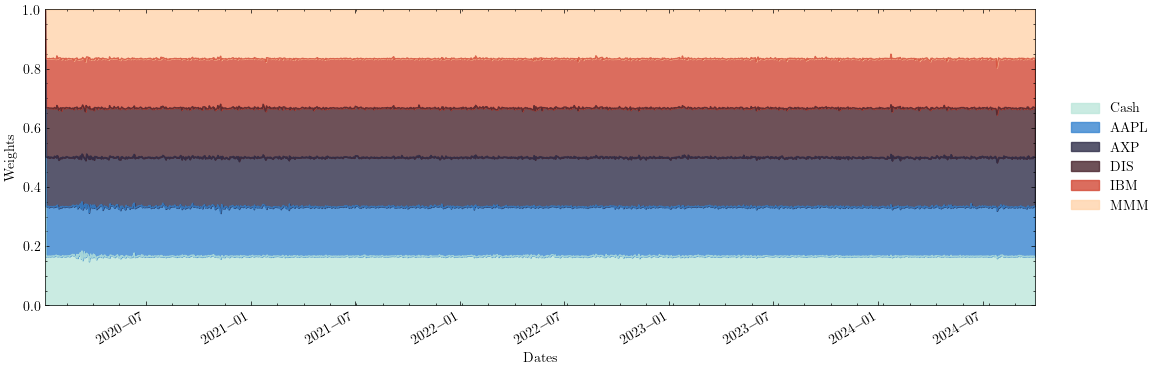

In [59]:
plot_buy_and_hold_weights(environment_train_buy_and_hold,test_data)


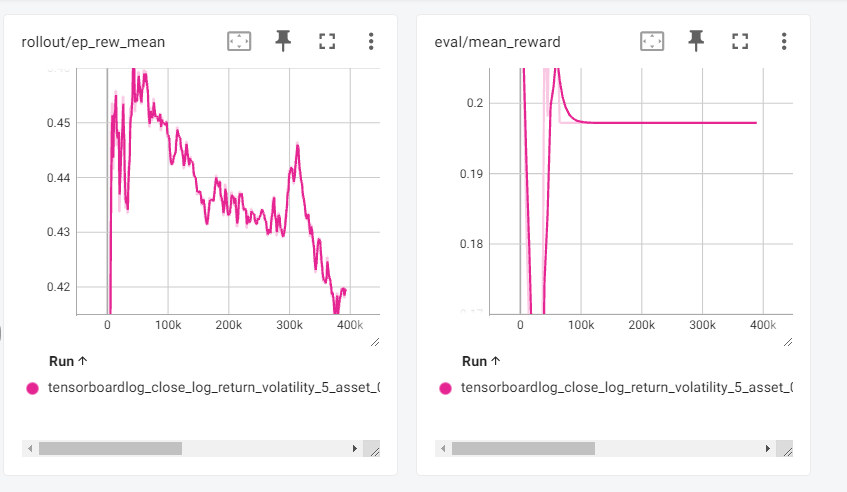

In [ ]:
result_a2c = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 21,
                         model_name='a2c'
                         ,iterations=iterations,comission_fee_model='trf',tag='5_asset_0.003_a2c'
                         ,transaction_fee = 0.003
                        # ,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset_0.003_a2c/a2c_60000_steps'
                         )

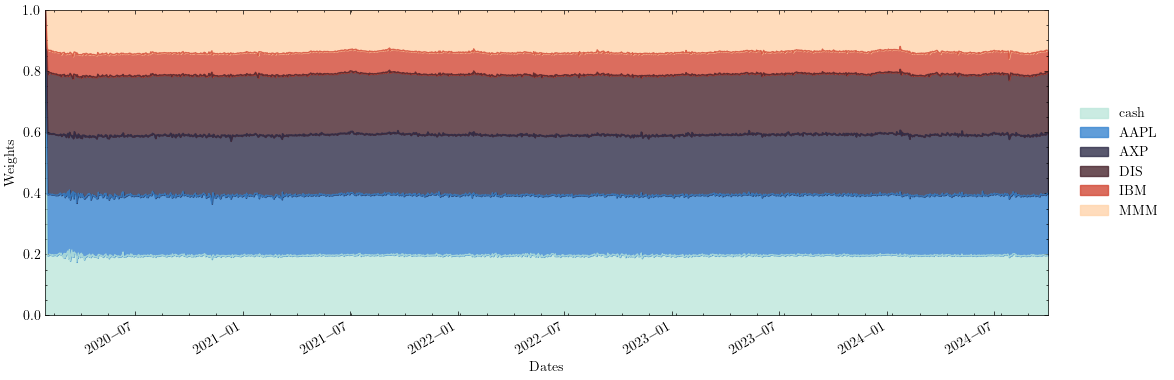

In [64]:
plot_weights(result_a2c,True,test_data)

# TD3 different windows 

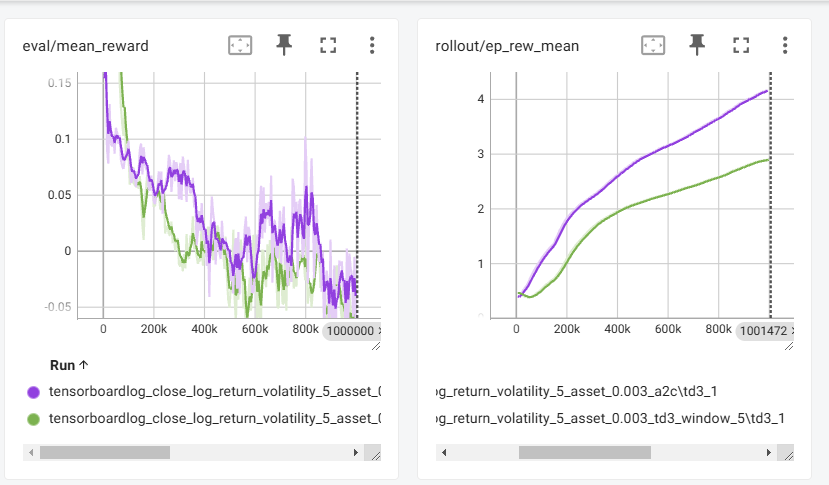

In [ ]:
result_td3 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 21,
                         model_name='td3'
                         ,iterations=iterations,comission_fee_model='trf',tag='5_asset_0.003_a2c'
                         ,transaction_fee = 0.003
                        # ,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset_0.003_a2c/a2c_60000_steps'
                         )

In [46]:
result_td3 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 5,
                         model_name='td3'
                         ,iterations=iterations,comission_fee_model='trf',tag='5_asset_0.003_td3_window_5'
                         ,transaction_fee = 0.003,policy_network="MultiInputPolicy"
                        ,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset_0.003_td3_window_5/td3_700000_steps'
                         )

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 157025.21875
Final accumulative portfolio value: 0.628100875
Maximum DrawDown: -0.5133760822999405
Sharpe ratio: -0.3250686862724448
hit end!


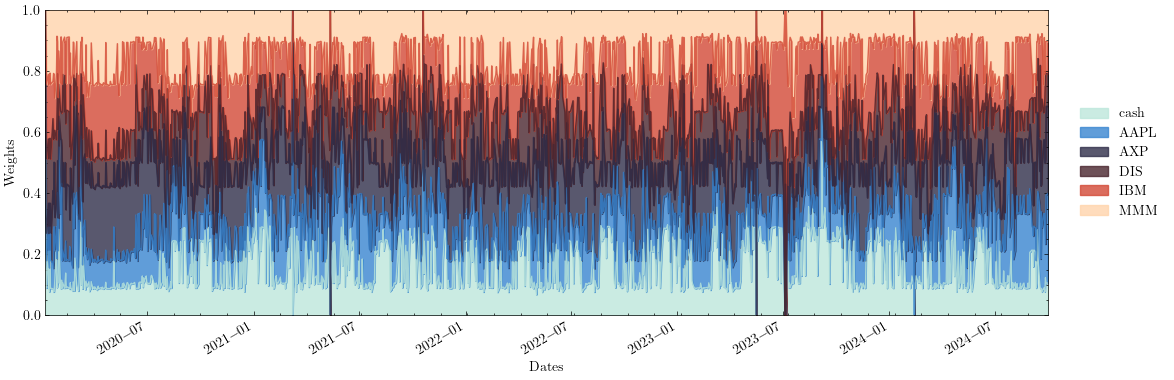

In [47]:
plot_weights(result_td3,True,test_data)

In [ ]:
result_ppo5 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 5,
                         model_name='ppo'
                         ,iterations=iterations,comission_fee_model='trf',tag='5_asset_0.003_ppo_window_5'
                         ,transaction_fee = 0.003
                        # ,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset_0.003_a2c/a2c_60000_steps'
                         )

# DAX

In [2]:
df = df_dax.copy()


In [3]:
df = df[df.tic.isin(['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BMW.DE', 'CON.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'VOW3.DE'])]

In [4]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2019-01-01'

VALIDATION_START_DATE = '2019-01-02'
VALIDATION_END_DATE = '2020-01-01'

TEST_START_DATE = '2020-01-02'
TEST_END_DATE = '2024-12-31'
INDICATORS = [
    "rsi",
    "atr",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2012-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 11


In [29]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'CON.DE', 'DB1.DE', 'DBK.DE', 'DTE.DE', 'DWNI.DE', 'EOAN.DE', 'FME.DE', 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LIN.DE', 'MRK.DE', 'MTX.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'VOW3.DE']
Columns retained after filtering: ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BMW.DE', 'CON.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'LIN.DE', 'VOW3.DE']


In [5]:
cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 11


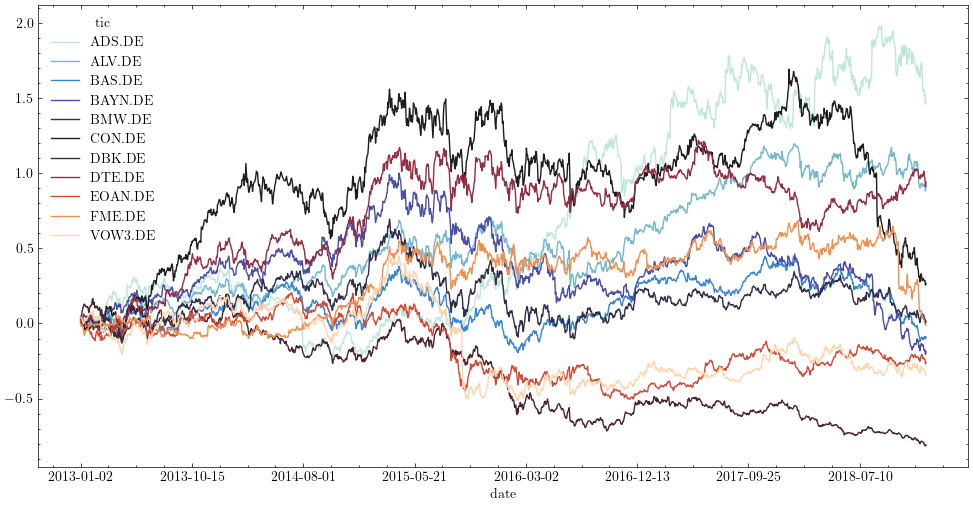

In [33]:
data = train_data
pv = data.pivot(values='return',columns='tic',index='date')
pv2 = data.pivot(values='log_return',columns='tic',index='date')

cumulative_return = (1 + pv).cumprod() -1
cumulative_return2 = (1 + pv2).cumprod() -1

%matplotlib inline
with plt.style.context('science','ieee'):
    pv = data.pivot(values='close',columns='tic',index='date')
    cumulative_return2.plot(figsize=(12, 6),colormap="icefire")
    

In [17]:
from archive.utils import mvo_data,mvo
correlation_data = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE)


In [8]:
min_variance_portfolio = mvo(correlation_data,pct=0)

begin_total_asset:50000
end_total_asset:60953.046340340166
Sharpe:  0.3189333170091122
Test Finished!
episode_return 1.2190609268068033


In [15]:
min_variance_fee_portfolio = mvo(correlation_data,pct=0.0001,multi_objective=True)

begin_total_asset:50000
end_total_asset:45825.04986362243
Sharpe:  0.006866878318584191
Test Finished!
episode_return 0.9165009972724486


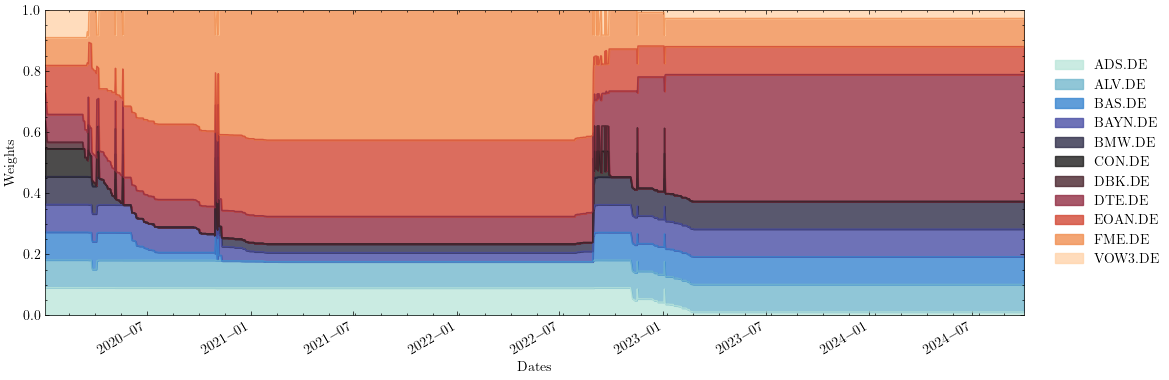

In [16]:
plot_mvo_weights(min_variance_fee_portfolio,test_data)

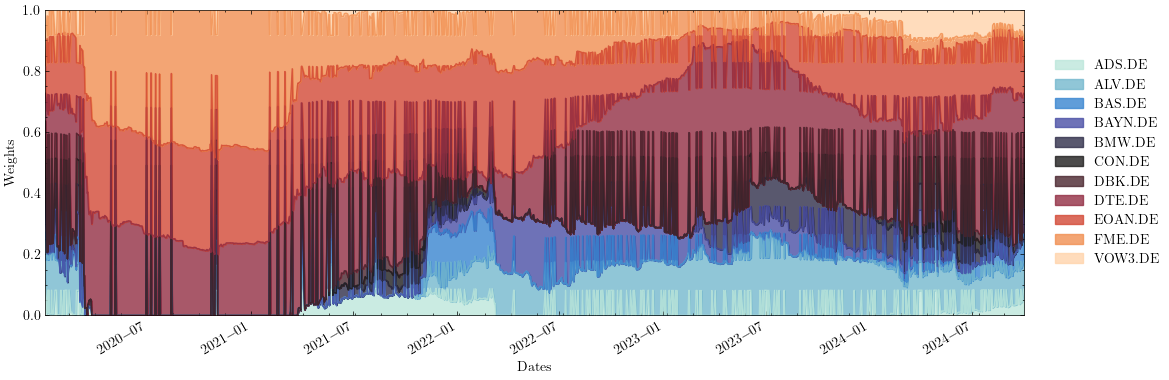

In [9]:
plot_mvo_weights(min_variance_portfolio,test_data)

In [63]:
max_sharpe_portfolio = mvo(correlation_data,pct=0.003,objective="sharpe",multi_objective=True,rf=0)

ValueError: at least one of the assets must have an expected return exceeding the risk-free rate

In [19]:
plot_mvo_weights(min_variance_portfolio,test_data)

NameError: name 'min_variance_portfolio' is not defined

In [88]:
iterations = 1_000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 1
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dax_window_1_fee_000.3_include_last_weight'
                         ,transaction_fee = 0.003,policy_network="MultiInputPolicy",
                         load=True,model_path='./data/history_main_close.log_return.volatility_dax_window_1_fee_000.3_include_last_weight/ppo_300000_steps'
                         )


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 236375.46875
Final accumulative portfolio value: 0.945501875
Maximum DrawDown: -0.38532744483733705
Sharpe ratio: 0.051976485165398
hit end!


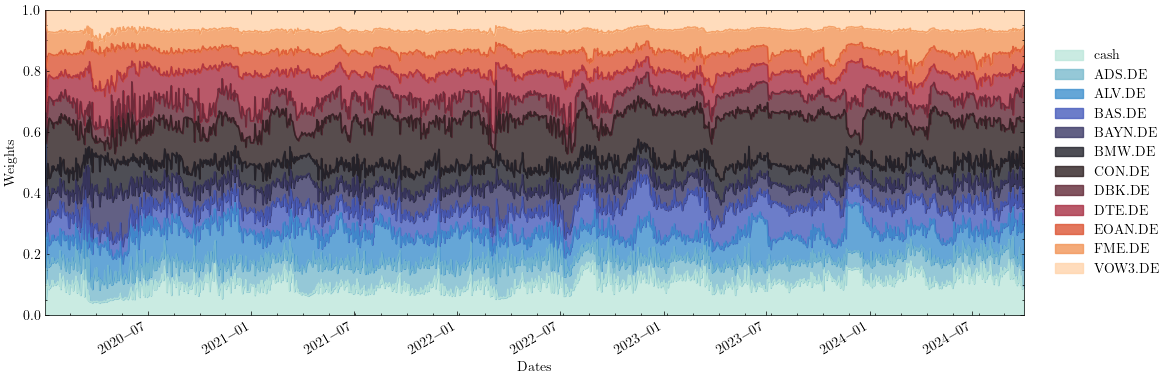

In [89]:
plot_weights(result_ppo,True,test_data)

In [57]:
iterations = 1_000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 5
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dax_window_5_fee_000.3_include_last_weight'
                         ,transaction_fee = 0.003,policy_network="MultiInputPolicy",
                        load=True,model_path='./data/history_main_close.log_return.volatility_dax_window_5_fee_000.3_include_last_weight/ppo_400000_steps'
                         )


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 228126.40625
Final accumulative portfolio value: 0.912505625
Maximum DrawDown: -0.38393427822890935
Sharpe ratio: 0.01886230650194108
hit end!


In [58]:
iterations = 1_000_000
result_ppo_no_fee = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None,t = 5
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dax_window_5_fee_000.3_include_last_weight'
                         ,transaction_fee = 0.00001,policy_network="MultiInputPolicy",
                        load=True,model_path='./data/history_main_close.log_return.volatility_dax_window_5_fee_000.3_include_last_weight/ppo_400000_steps'
                         )


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 325916.3125
Final accumulative portfolio value: 1.30366525
Maximum DrawDown: -0.37735337878028885
Sharpe ratio: 0.36545319020788475
hit end!


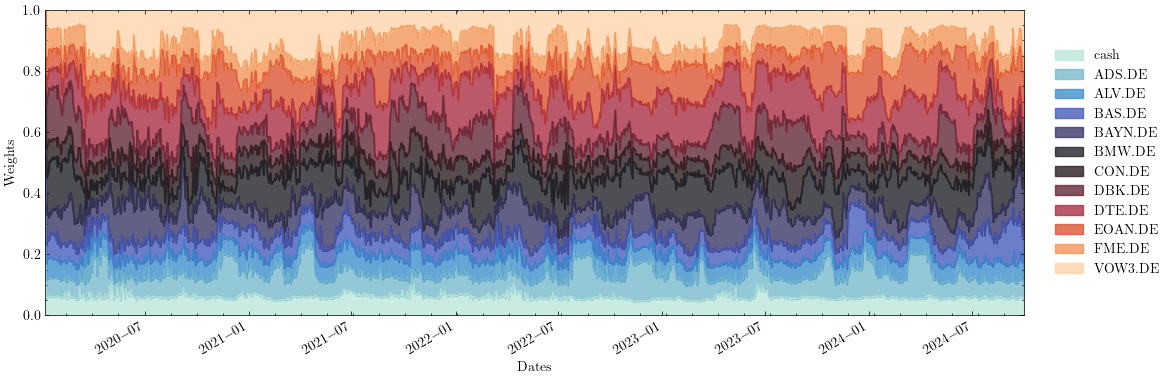

In [9]:
plot_weights(result_ppo,True,test_data)

windows size 1 vs 5

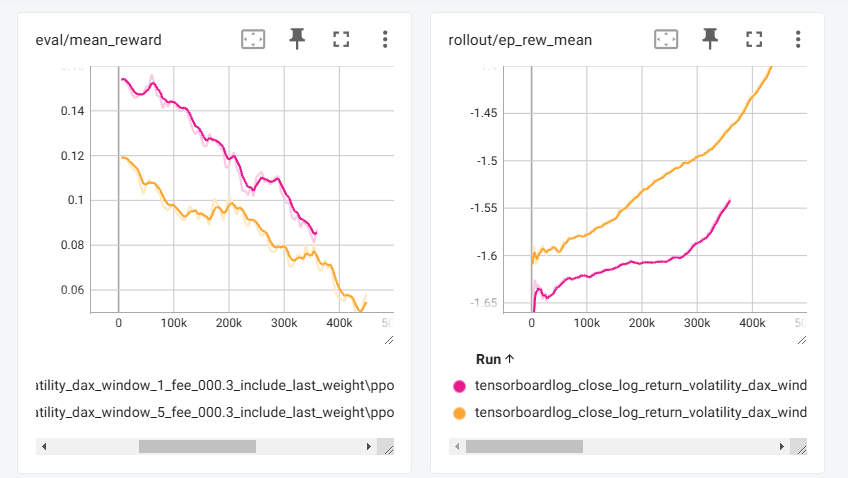

In [15]:
stock_dimension = len(test_data.tic.unique()) +1

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.003,
    
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1201209.375
Final accumulative portfolio value: 1.201209375
Maximum DrawDown: -0.3678500176018096
Sharpe ratio: 0.2873356908998654


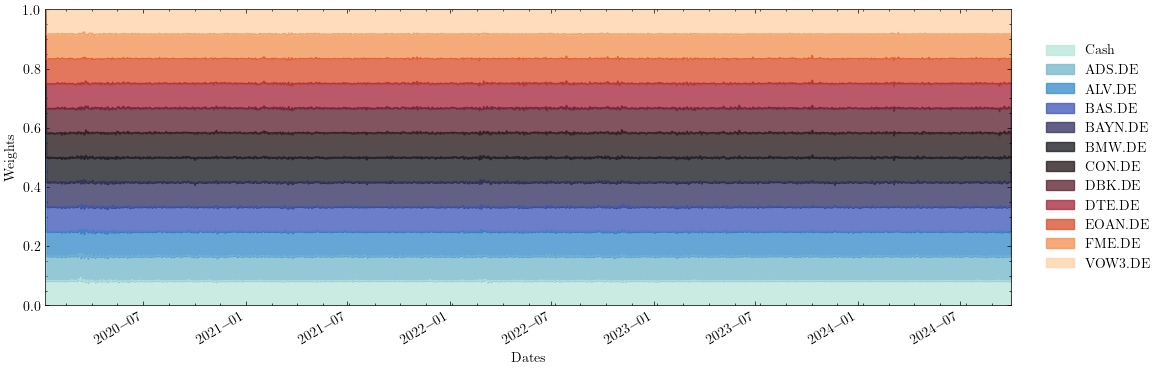

In [13]:
plot_buy_and_hold_weights(environment_train_buy_and_hold,test_data)


In [42]:
min_variance_portfolio['test']

date       account    return     method
0    2020-01-03  50000.000000  0.000000  markowitz
1    2020-01-06  49618.204299  0.992364  markowitz
2    2020-01-07  49820.508257  0.996410  markowitz
3    2020-01-08  49643.781146  0.992876  markowitz
4    2020-01-09  50164.139940  1.003283  markowitz
...         ...           ...       ...        ...
1208 2024-09-25  18676.524547  0.373530  markowitz
1209 2024-09-26  18668.277145  0.373366  markowitz
1210 2024-09-27  18818.552531  0.376371  markowitz
1211 2024-09-30  18589.020929  0.371780  markowitz
1212 2024-09-30  18589.020929  0.371780  markowitz

[1213 rows x 4 columns]

In [52]:
environment_train_buy_and_hold._asset_memory

{'initial': [1000000,
  1000000.0,
  1012452.7949461504,
  1014300.7694977105,
  1008461.667829311,
  1011987.8721607073,
  1009505.7611662227,
  1006376.1567608299,
  1008809.7396176459,
  1010379.2029961467,
  1010440.2711976446,
  1008412.2311757366,
  999683.0449808651,
  1006470.809961256,
  985060.7979891907,
  998405.1027523727,
  994974.4172580349,
  986516.738555297,
  976726.5028782822,
  976776.0403119473,
  989485.913326639,
  1004752.0772842943,
  1019795.6185005952,
  1014329.6712601598,
  1009291.0423217166,
  1021285.9721262723,
  1039386.6693415514,
  1038195.4891475294,
  1038530.9955164959,
  1043013.0971547733,
  1033318.5606668035,
  1041721.452830769,
  1039256.8358413813,
  1029643.2341153941,
  991321.7385023559,
  975031.3858582585,
  977079.4837563727,
  947671.4807766574,
  922479.6992715133,
  916335.9269199105,
  919894.0273530085,
  929245.1072608185,
  908239.174663707,
  888989.0476845186,
  820566.9777591684,
  807752.6453723478,
  800769.0808005332,
  

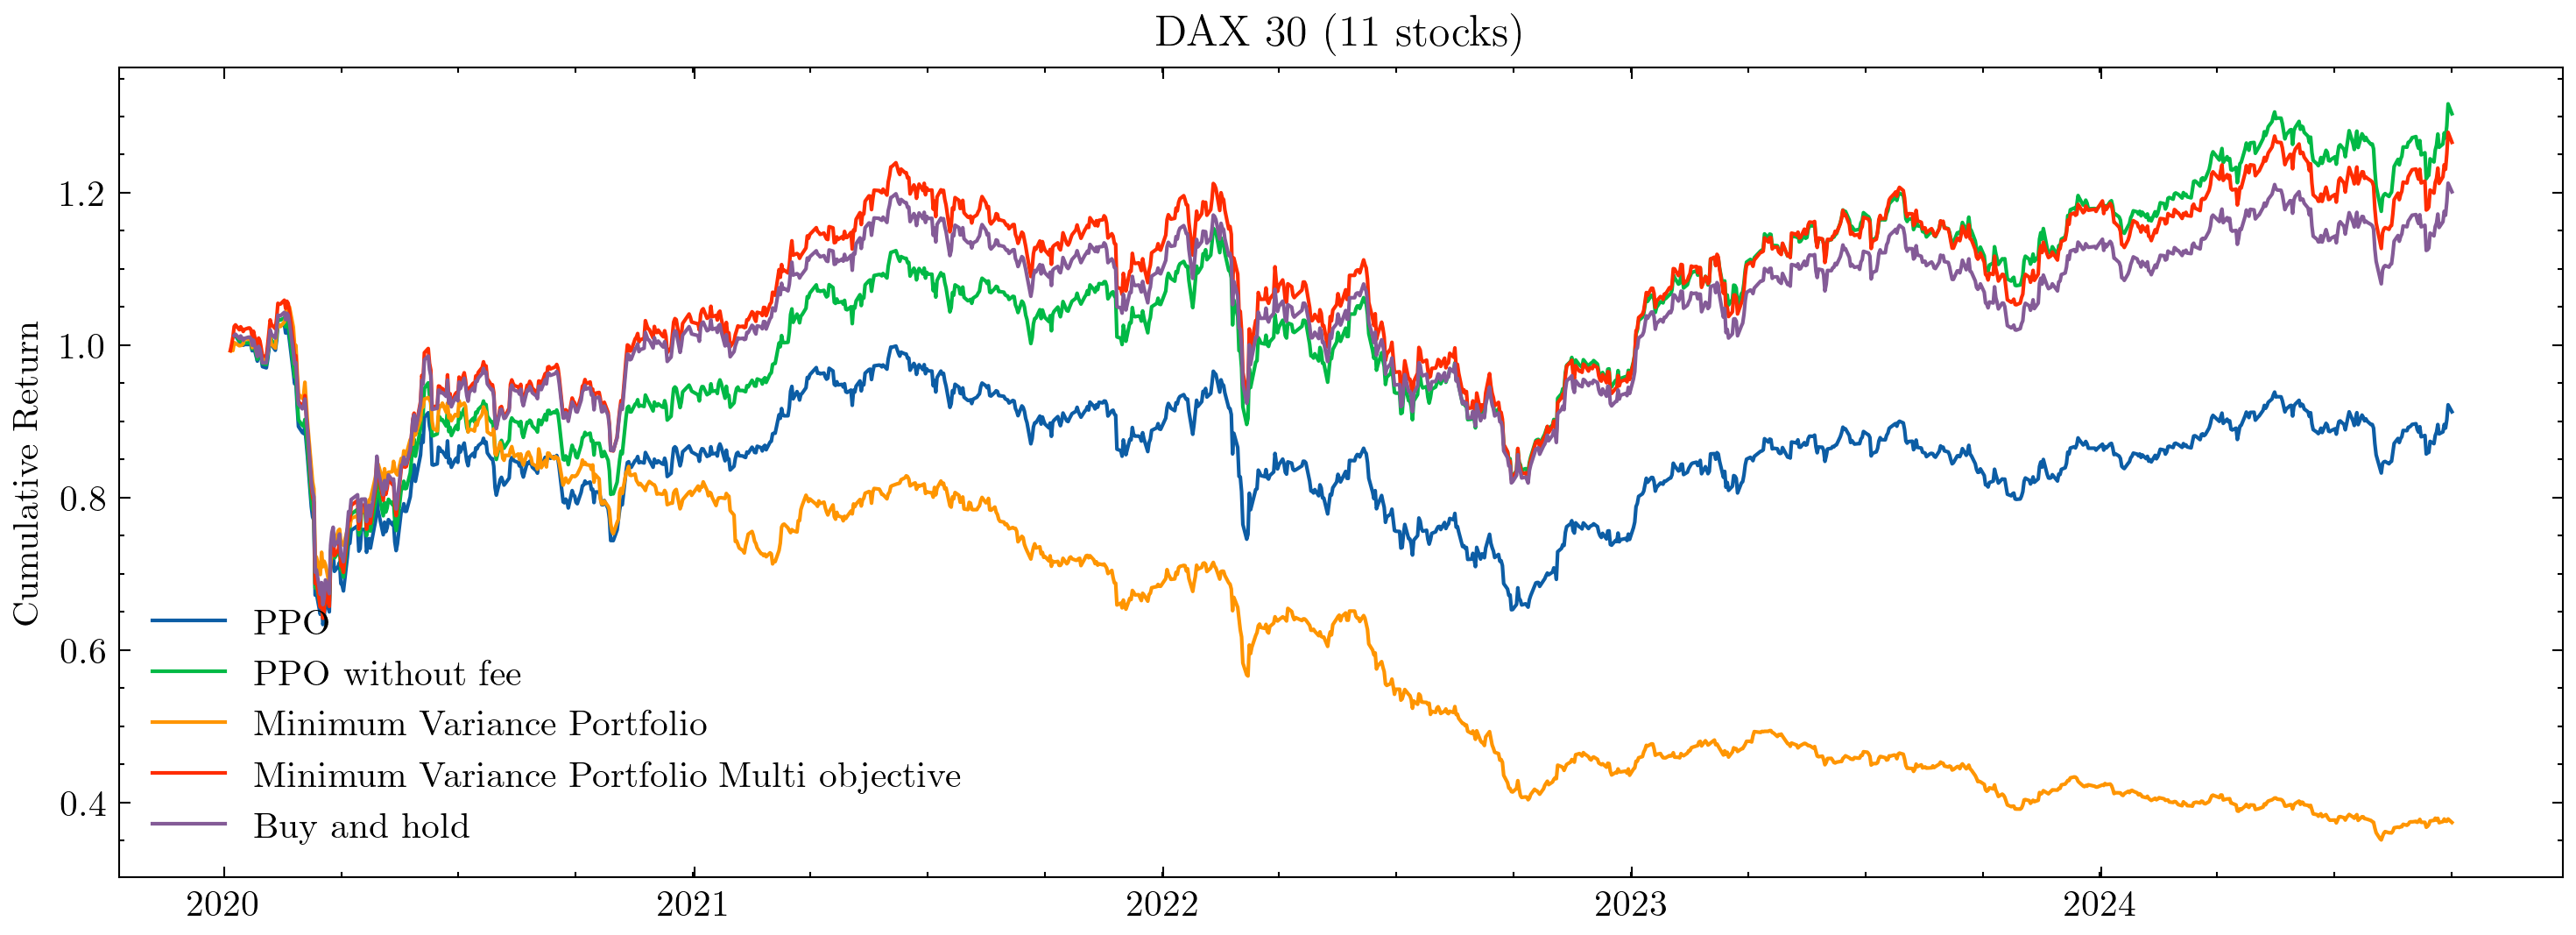

In [66]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(result_ppo_no_fee['test'][0].get('date'),(result_ppo_no_fee['test'][0]['account'].pct_change() +1).cumprod(),label='PPO without fee')
    plt.plot(min_variance_portfolio['test'].date,(min_variance_portfolio['test'].account.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(min_variance_fee_portfolio['test'].date,(min_variance_fee_portfolio['test'].account.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio Multi objective')
    plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DAX 30 (11 stocks)')
    plt.show()